This program compare ARIMA, ANN, and combination of them as hybrid method to predict time series data

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import util as utl
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn import preprocessing
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.layers.recurrent import LSTM
from statsmodels.tsa.stattools import pacf, acf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cfg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn import preprocessing
from statsmodels.tsa.stattools import acf
from keras.layers import LSTM

Loading data from dataset and showing raw data

total samples: 1827


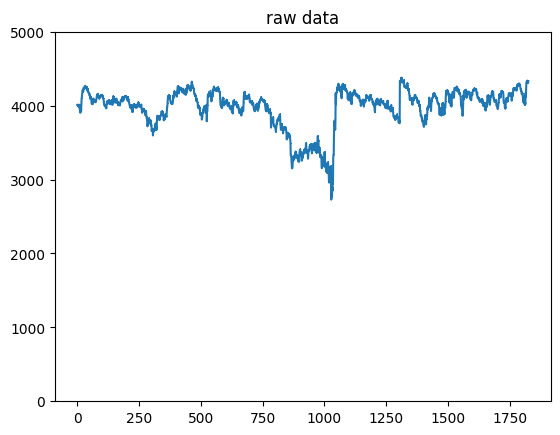

In [2]:
# loading data
ls_data = utl.read_data(cfg.csv_path)
#ls_data = ls_data[0:1000]
start_outlayer = 50
# showing data
plt.close('all')
plt.title('raw data')
plt.ylim(cfg.ylim)
plt.plot(ls_data, marker=',')
plt.show()

Splitting data into test and train

In [3]:

trn_count = int(len(ls_data) * cfg.trn_sz)
train, test = ls_data[0:trn_count], ls_data[trn_count:len(ls_data)]

print('# sample train: ' + str(trn_count))
print('# sample test: ' + str(len(test)))


# sample train: 913
# sample test: 914


Training ARIMA in rolling mode

In [4]:
model = ARIMA(train,
              order=(
                  cfg.ARIMA_p1,
                  cfg.ARIMA_p2,
                  cfg.ARIMA_p3))

model_fit = model.fit()

Measuring auto correlation function and partial auto correlation function

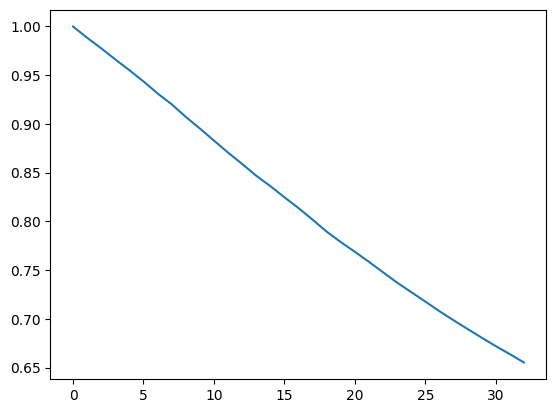

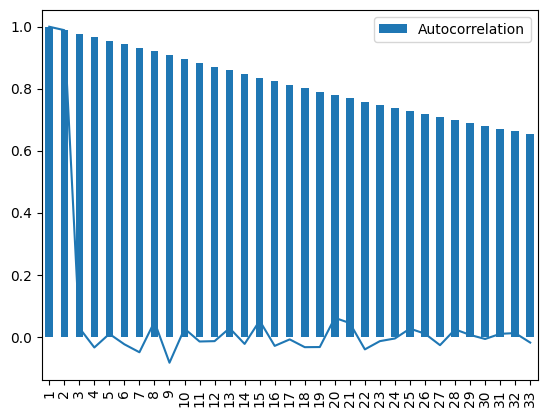

In [5]:
auto_corr_func = acf(ls_data)
plt.plot(auto_corr_func)
df = pd.DataFrame([auto_corr_func]).T
df.columns = ["Autocorrelation"]
df.index += 1
df.plot(kind='bar')
par_auto_corr_func = pacf(ls_data)
plt.plot(par_auto_corr_func)
plt.show()
#test_df = pd.DataFrame([pacf_1]).T


Training ARIMA in rolling mode

In [6]:
arima_pred, resid_test = [], []
history = train
for t in range(len(test)):
    model = ARIMA(history,
                  order=(
                      cfg.ARIMA_p1,
                      cfg.ARIMA_p2,
                      cfg.ARIMA_p3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    resid_test.append(test[t] - output[0])
    arima_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    if cfg.shw_ARIMA:
        print(
            str(t) + ' - ' + 'predicted=%f, expected=%f' % (yhat, obs))

D:\projects\ARIMA_ANN\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Printing and visualizing ARIMA performance of rolling mode

MSE (ARIMA): 16162811.670
ME (ARIMA): 4010.229
MAE (ARIMA): 4010.229
MAPE (ARIMA): 294374.249


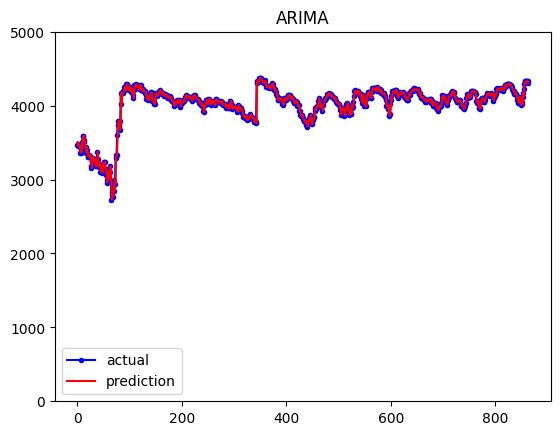

In [7]:
test_resid = []
for i in resid_test:
    test_resid.append(i)
    
utl.print_errors(
    'ARIMA',
    test_resid[start_outlayer:],
    arima_pred[start_outlayer:])

plt.title('ARIMA')
plt.ylim(cfg.ylim)
plt.plot(
    test[start_outlayer:],
    label='actual',
    color='blue',
    marker='.')
plt.plot(
    arima_pred[start_outlayer:],
    label='prediction',
    color='red',
    marker=',')
plt.legend()
plt.show()

All mode training of ARIMA

In [8]:
#train, test = ls_data[0:trn_count], ls_data[trn_count:len(ls_data)]
model = ARIMA(
    train,
    order=(
        cfg.ARIMA_p1,
        cfg.ARIMA_p2,
        cfg.ARIMA_p3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1827
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -9318.188
Date:                Thu, 18 Apr 2024   AIC                          18642.376
Time:                        13:03:09   BIC                          18658.907
Sample:                             0   HQIC                         18648.474
                               - 1827                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3975.3326    102.174     38.908      0.000    3775.075    4175.590
ar.L1          0.9889      0.002    406.940      0.000       0.984       0.994
sigma2      1572.9270     13.672    115.047      0.0

Residual diagnostics and additional info of all mode training

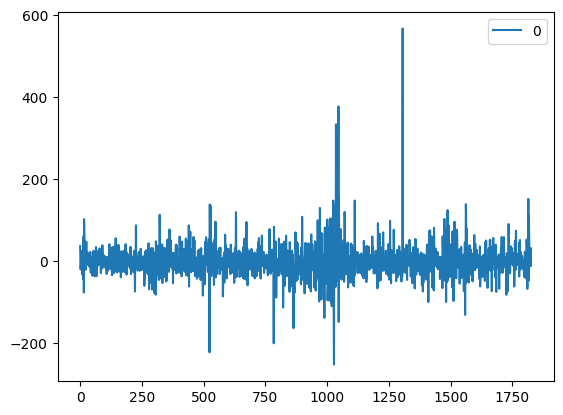

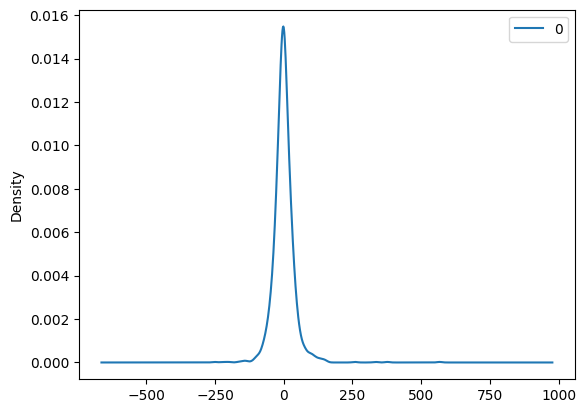

                 0
count  1827.000000
mean      0.192600
std      39.676949
min    -252.912235
25%     -18.102869
50%      -0.598100
75%      16.204625
max     567.429868


In [9]:
more_info = pd.DataFrame(model_fit.resid)
more_info.plot()
plt.show()
more_info.plot(kind='kde')
plt.show()
print(more_info.describe())

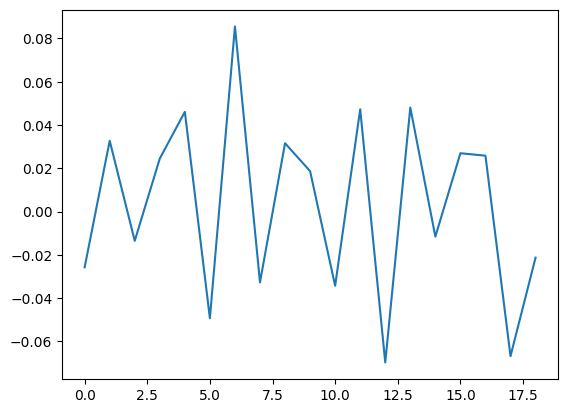

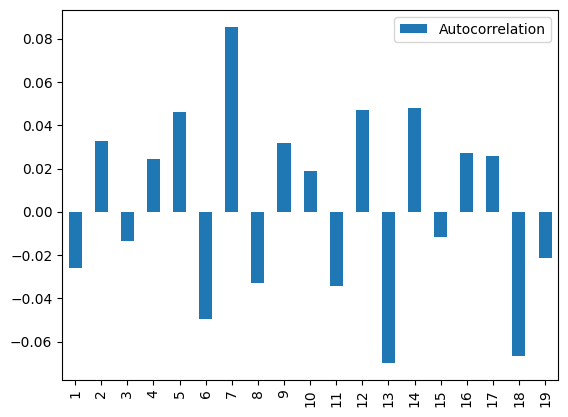

In [10]:
# plot the acf for the residuals
auto_corr_func = acf(model_fit.resid)[1:20]
plt.plot(auto_corr_func)
test_df = pd.DataFrame([auto_corr_func]).T
test_df.columns = ["Autocorrelation"]
test_df.index += 1
test_df.plot(kind='bar')
plt.show()

Training ANN

In [11]:
# choose model type
if (cfg.model_type == 'lstm'):
    model = utl.make_lstm_model()
else:
    model = utl.make_model(cfg.win_sz)

#normalizing input data
mms = preprocessing.MinMaxScaler()
train = np.array(train).reshape(-1, 1)
# todo may test must be used here
train_scaled = mms.fit_transform(train)

# moving window by window
train_x, train_y = [], []
for i in range(0, len(train_scaled) - cfg.win_sz):
    train_x.append(train_scaled[i:i + cfg.win_sz])
    train_y.append(train_scaled[i + cfg.win_sz])

new_train_X, new_train_Y = [], []
for i in train_x:
    new_train_X.append(i.reshape(-1))
for i in train_y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)

his = model.fit(
    new_train_X, new_train_Y,
    epochs=cfg.epoch,
    batch_size=cfg.batch_sz,
    validation_split=cfg.vld_spl,
    verbose=cfg.verbose)

D:\projects\ARIMA_ANN\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Drawing train vs validation loss value

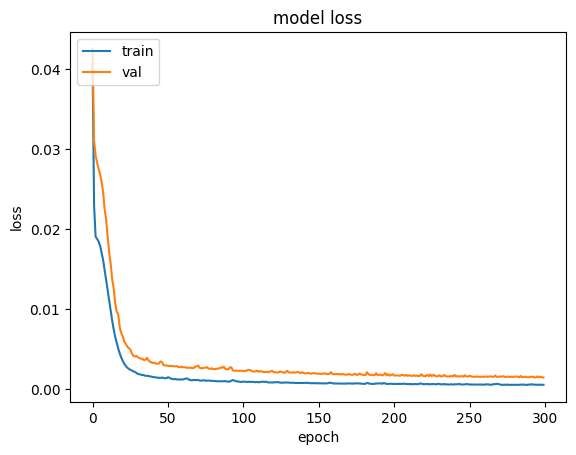

In [12]:
# draw ann performance
utl.draw_nn_perf(his)


moving window by window for testing data and normalizing data

In [13]:
test_extended = train.tolist()[-1 * cfg.win_sz:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1, 1)

# normalizing test data
mms = preprocessing.MinMaxScaler()
test_scaled = mms.fit_transform(test_data)
test_X, test_Y = [], []
for i in range(0, len(test_scaled) - cfg.win_sz):
    test_X.append(test_scaled[i:i + cfg.win_sz])
    test_Y.append(test_scaled[i + cfg.win_sz])
    new_test_X, new_test_Y = [], []
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)

# denormalizing test data
predictions = model.predict(new_test_X)
predictions_rescaled = mms.inverse_transform(predictions)
y = pd.DataFrame(new_train_Y)
#pred = pd.DataFrame(predictions)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Visualizing predicted (by ANN) data vs actual data

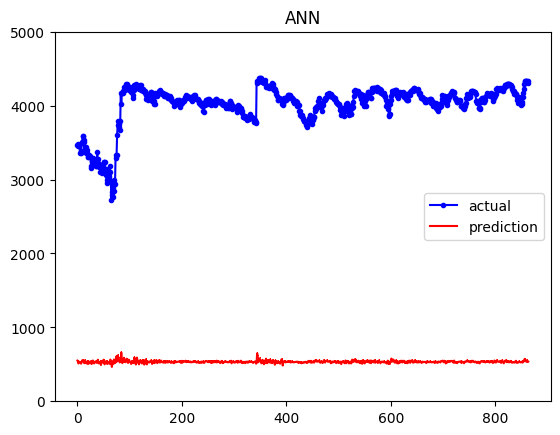

In [14]:
plt.ylim(cfg.ylim)
plt.plot(
    test[start_outlayer: len(predictions)],
    label='actual',
    color='blue',
    marker='.')
tmp = predictions_rescaled[start_outlayer:]
plt.plot(
    tmp,
    label='prediction',
    color='red',
    marker=',')
plt.title('ANN')
plt.legend()
plt.show()

Printing ANN performance 

In [15]:
utl.print_errors(
    'ANN',
    test[start_outlayer:],
    predictions_rescaled[start_outlayer:])

print(50*'#')

MSE (ANN): 12187473.071
ME (ANN): -3480.016
MAE (ANN): 3480.016
MAPE (ANN): 86.614
##################################################


Mixing ANN and ARIMA as hybrid method

In [16]:
predictions_rescaled = predictions_rescaled.squeeze()
pred_hybrid = predictions_rescaled + arima_pred

# removing DC offset
m1 = np.mean(pred_hybrid)
m2 = np.mean(test)
pred_hybrid += m2 - m1


Visualizing and printing performance of hybrid method

MSE (Hybrid): 2790.432
ME (Hybrid): -14.789
MAE (Hybrid): 33.032
MAPE (Hybrid): 0.849


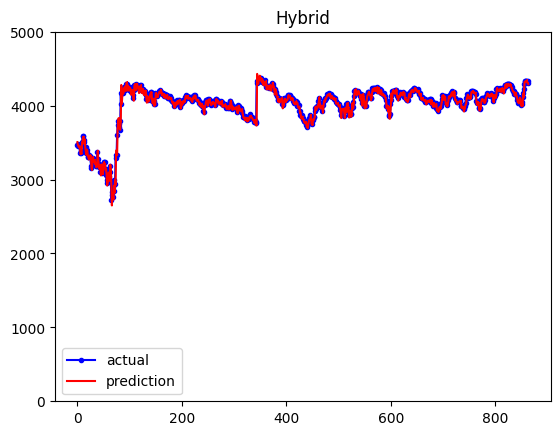

In [17]:
utl.print_errors(
    'Hybrid',
    test[start_outlayer:],
    pred_hybrid[start_outlayer:])

#y = pd.DataFrame(test)
#pred = pd.DataFrame(pred_hybrid)
plt.plot(
    test[start_outlayer:],
    label='actual',
    color='blue',
    marker='.')
plt.plot(
    pred_hybrid[start_outlayer:],
    label='prediction',
    color='red',
    marker=',')
plt.title('Hybrid')
plt.ylim(cfg.ylim)
plt.legend()
plt.show()



Drawing 45 degree graphs

regression line degree(Hybrid method): 44.37
regression line degree(Hybrid method): 101.39870758933739
regression R2(Hybrid method): 0.9675189810456543
regression line degree(Arima method): 44.74
regression line degree(Arima method): 38.93302081218917
regression R2(Arima method): 0.9714496050167984
regression line degree(ANN method): 69.4
regression line degree(ANN method): 2592.351
regression R2(ANN method): 0.02258075750876476


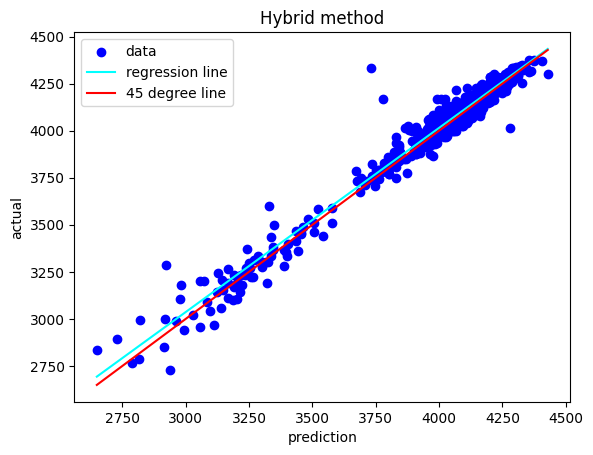

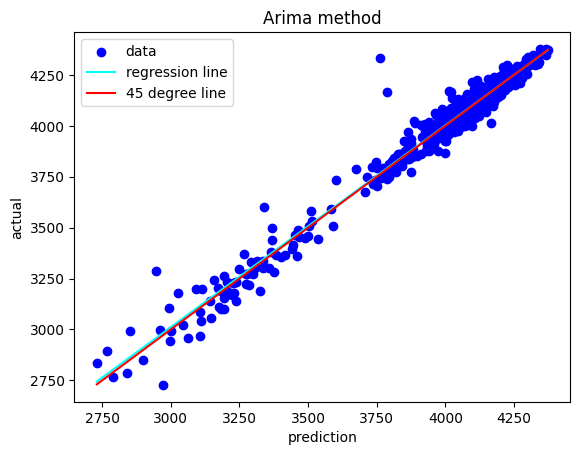

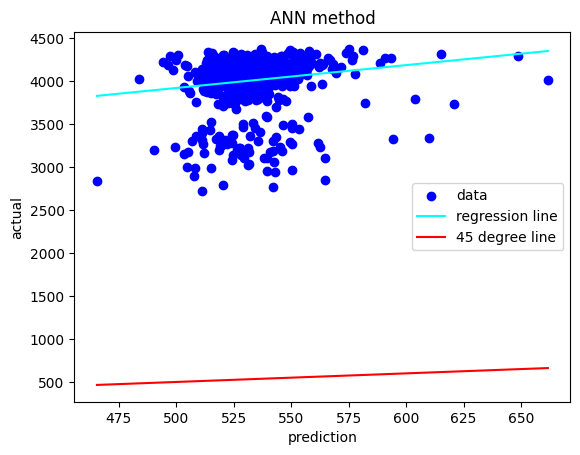

In [18]:
utl.show_45_deg_stats(
    'Hybrid method',
    test[start_outlayer:],
    pred_hybrid[start_outlayer:])

utl.show_45_deg_stats(
    'Arima method',
    test[start_outlayer:],
    arima_pred[start_outlayer:])

utl.show_45_deg_stats(
    'ANN method',
    test[start_outlayer:],
    predictions_rescaled[start_outlayer:])
